### **Using Convolutional and Recurrent Methods for Sequence Models**

Look at **additional techniques** that may further enhance the ability to predict sequence data using ***convolutional neural networks*** as well as ***recurrent neural networks***.

Explored **different network types** for building models to predict time series data.

Built on the simple DNN, **adding convolutions** and experimented with **recurrent network types** such as **simple RNNs**, **GRUs**, and **LSTMs**.

Tweak **hyperparameters** and **the network architecture** to improve the model’s accuracy.

Practice working with some **real-world datasets** including one massive dataset with hundreds of years’ worth of temperature readings.

Get started building networks for **a variety of datasets** with a good understanding of what need to know to **optimize them**.

### **Convolutions for Sequence Data**

Apply **convolutions** to **numeric time series data** and the convolution will be **one-dimensional** instead of **two-dimensional**.

*EX - the series of numbers*

<center>

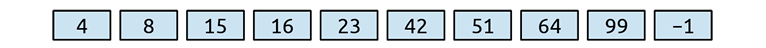
<caption>A sequence of numbers</caption>

</center>

Consider a 1D convolution to be a **`1 × 3`** filter with filter values of **`–0.5, 1, –0.5`**, respectively $\rightarrow$ the **first value** in the sequence will be **lost**, and the **second value** will be **transformed** from **8** to **-1.5**.

<center>

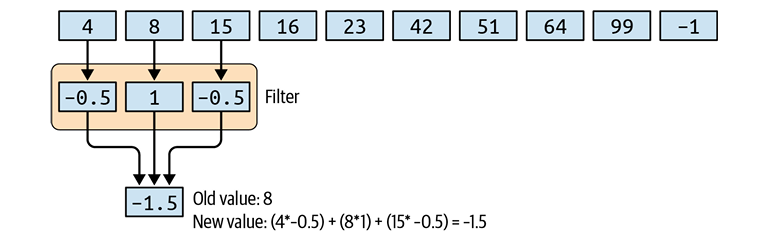
<caption>Using a convolution with the number sequence</caption>

</center>

The **filter** then *stride across* the values, calculating new ones as it goes $\rightarrow$ in **the next stride** **15** will be transformed to **3**.

<center>

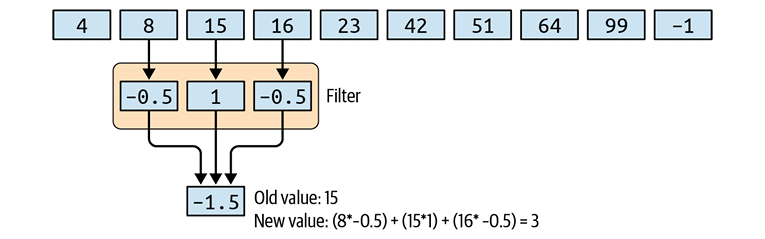
<caption>An additional stride in the 1D convolution</caption>

</center>

Using this method $\rightarrow$ ***extract the patterns between values*** and ***learn the filters that extract them successfully*** - in much the same way as convolutions on the pixels in images are able to extract features. In this instance there are **NO labels** but the convolutions that **minimize overall loss** could be learned.

### **Coding Convolutions**

Before coding convolutions $\rightarrow$ have to **adjust the windowed dataset generator** because when coding the convolutional layers _ **have to specify the dimensionality**. 

**The windowed dataset was a single dimension** but it wasn’t defined as a 1D tensor $\rightarrow$ requires adding a **`tf.expand_dims`** statement at the beginning of the **`windowed_dataset`** function $\rightarrow$ From **`(n,)`** to **`(n, 1)`**

Expand the last dimension once
```python
series = tf.expand_dims(series, axis=-1)  # Adds one dimension at the last axis
```

Expand in two places (e.g., making it 4D from 2D or 3D)
```python
series = tf.expand_dims(series, axis=[-1, -2])  # Adds two new dimensions at the end then at the previous end
series = tf.expand_dims(series, axis=[-1, -1]) # Adds two new dimensions at the end then at the end
```

Expand the first dimension once
```python
series = tf.expand_dims(series, axis=0)  # Adds a new dimension at the start
```

In [173]:
import tensorflow as tf
from keras_tuner import RandomSearch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [70]:
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [71]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + noise(time, noise_level, seed=42)

series.shape

(1461,)

In [72]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # window_size + 1 because have to include the target value
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # flat_map() instead of map() to flatten the windows into one large dataset
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [73]:
split_time = 1000
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [74]:
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

Have an amended dataset $\rightarrow$ add a convolutional layer ***before*** the dense layers

In [75]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, 
                           kernel_size=3, 
                           strides=1, 
                           padding="causal", 
                           activation="relu", 
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1574.4470
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146.7452
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.5953
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.2216
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84.3100
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.9167
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.9805
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73.3307
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68.1366
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.5919
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.5764
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66.2226
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63.4877
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.0947
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

**Conv1D layer** - a number of parameters:

**`filters`** - is the number of filters that the layer has to learn. It will **generate this number**, and **adjust them over time to fit the data as it learns**.

**`kernel_size`** - is the size of the filter 

**`strides`** - is the size of the **step** that the filter will take as it scans across the list. This is typically **1**.

**`padding`** - determines the behavior of the list with regard to which end data is dropped from. A **`3 × 1`** filter will **lose** the *first* and *last* value of the list $\rightarrow$ can **NOT calculate** *the prior value* for the *first* or *the subsequent value* for the *last*. 

Typically with **sequence data** $\rightarrow$ use **`causal`** which only take data from the **current** and **previous time steps** - **never future ones** $\rightarrow$ a **`3 × 1`** filter take the current time step along with the previous two. 


**`activation`** - is the activation function $\rightarrow$ use **`relu`** $\rightarrow$ effectively **reject negative values** coming out of the layer.

**`input_shape`** - is the input shape of the data being passed into the network. As the **first layer** $\rightarrow$ have to specify it.


Instead of predicting each value, one by one, based on the previous window $\rightarrow$ **get a single prediction for an entire series** if correctly formatted the series as a dataset. 

To simplify things a bit, here’s **a helper function** that **can predict an entire series based on the model**, with a specified window size:

In [76]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Use the model to predict this series $\rightarrow$ **pass** the series in with **a new axis** to **handle the Conv1Ds needed for the layer with the extra axis**.

In [77]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Split this **`forecast`** into just the predictions for the validation set using the predetermined split time

In [78]:
results = forecast[split_time - window_size:-1, -1, 0]

In [79]:
results.shape

(461,)

In [80]:
# Create metric objects
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Update state with actual and predicted values
mae_metric.update_state(series_valid, results)

# Get the result
mae = mae_metric.result().numpy()

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 4.626197


The MAE is **slightly worse** than for the previous prediction $\rightarrow$ because haven’t **tuned** the convolutional layer **appropriately** or the convolutions **don’t help**.

This data has **a random element** in it $\rightarrow$ values will **change across sessions**.

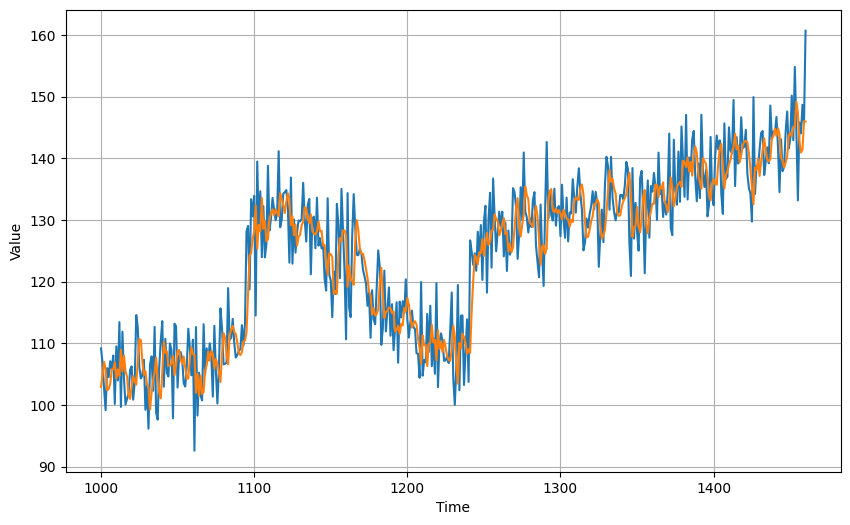

In [81]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    if label:
        plt.legend()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, results)

When using convolutions, the question always comes up: 
- *Why choose the parameters that we chose?* 
- *Why 128 filters?* 
- *Why size 3 × 1?* 

Can experiment with them using **`Keras Tuner`**

### **Experimenting with the Conv1D Hyperparameters**

A 1D convolution that was **hardcoded** with parameters $\rightarrow$ when training the neural network, **the MAE** *went up slightly* $\rightarrow$ got **NO** benefit from using the Conv1D. 

$\Rightarrow$ **May not always be the case**, depending on the data, but it could be because of **suboptimal hyperparameters**.

$\Rightarrow$ Use **`Keras Tuner`** to optimize them.

In [82]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(
                filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                padding='causal', 
                activation='relu', 
                input_shape=[None, 1]
    ))
    model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))      
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss="mse", 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5))
    return model

- The **`filter`** values start at **128** and step upwards toward **256** in increments of **64**. 

- The **`kernel size`** starts at **3** and increase to **9** in steps of **3**

- The **`strides`** starts at **1** and be stepped up to **3**.

A lot of combinations of values  $\leftrightarrow$ take some time to run.

In [83]:
tuner = RandomSearch(build_model, objective='loss', 
                    max_trials=500, executions_per_trial=3, 
                    directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()
tuner.search(dataset, epochs=100, verbose=2)

Reloading Tuner from my_dir\cnn-tune\tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
kernels (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 9, 'step': 3, 'sampling': 'linear'}
strides (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}


In [84]:
tuner.results_summary()

Results summary
Results in my_dir\cnn-tune
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 002 summary
Hyperparameters:
units: 128
kernels: 9
strides: 1
Score: 59.767433166503906

Trial 008 summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 60.03289922078451

Trial 020 summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
Score: 60.113189697265625

Trial 005 summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 60.19506708780924

Trial 000 summary
Hyperparameters:
units: 256
kernels: 6
strides: 2
Score: 61.511756896972656

Trial 012 summary
Hyperparameters:
units: 256
kernels: 9
strides: 2
Score: 61.59209696451823

Trial 009 summary
Hyperparameters:
units: 192
kernels: 3
strides: 1
Score: 61.60833867390951

Trial 011 summary
Hyperparameters:
units: 128
kernels: 6
strides: 2
Score: 61.62811533610026

Trial 004 summary
Hyperparameters:
units: 256
kernels: 3
strides: 1
Score: 61.6691042582194

Trial 018 summary
Hyperparameters:
units: 192

128 filters, with size 9 and stride 1, gave **the best results**.

The **`filter size`** makes sense with such **a large body of data**. With a **`filter size`** of **3** - only the **immediate neighbors** have an impact, whereas with **9** - **neighbors further afield** also have an impact on the result of applying the filter.

In [85]:
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=128, kernel_size=9, strides=1, padding="causal", activation="relu",  input_shape=[None, 1]),
            tf.keras.layers.Dense(28, input_shape=[window_size], activation="relu"), 
            tf.keras.layers.Dense(10, activation="relu"), 
            tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1413.4006
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135.4519
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85.4135
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.6290
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.3937
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.1747
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.1850
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.9221
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.1073
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.5004
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.9300
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.8807
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.9248
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.5963
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

After training with this, the model **had improved accuracy** compared with **both the naive CNN** and the original **DNN**

In [86]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [87]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)

results = forecast[split_time - window_size:-1, -1, 0]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [88]:
# Create metric objects
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Update state with actual and predicted values
mae_metric.update_state(series_valid, results)

# Get the result
mae = mae_metric.result().numpy()

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 4.612279


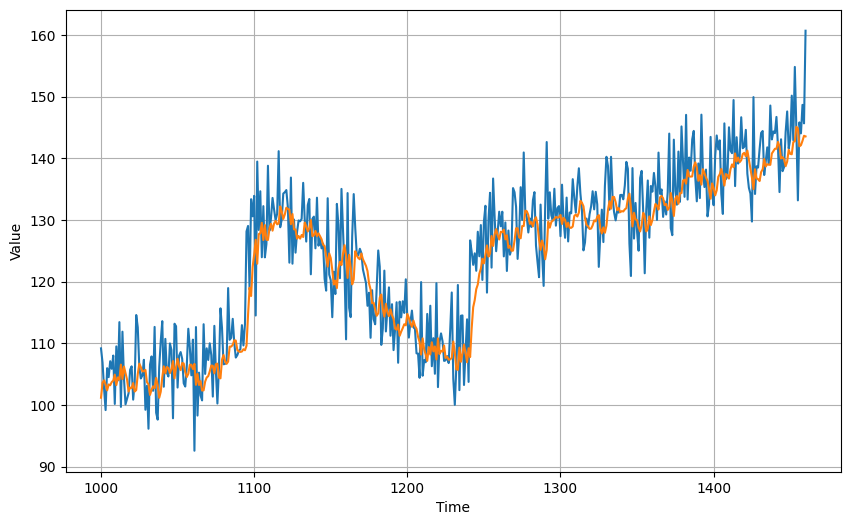

In [89]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    if label:
        plt.legend()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, results)

This resulted in an MAE is a slight improvement $\rightarrow$ further experimentation with the CNN hyperparameters may improve this further.


Beyond convolutions, the techniques **on natural language processing with RNNs**, including **LSTMs** may be **powerful** when working with **sequence data**. 

By their very nature, RNNs are designed for **maintaining context** $\rightarrow$ previous values can have **an effect on later ones**.

### **Using NASA Weather Data**

One great resource for time series weather data is **the NASA Goddard Institute for Space Studies (GISS) Surface Temperature analysis**.

Go to **Station Data** [on the right side of the page] $\rightarrow$ pick a weather station to get data from.

EX - the Seattle Tacoma (SeaTac) airport and was taken to the page

<center>

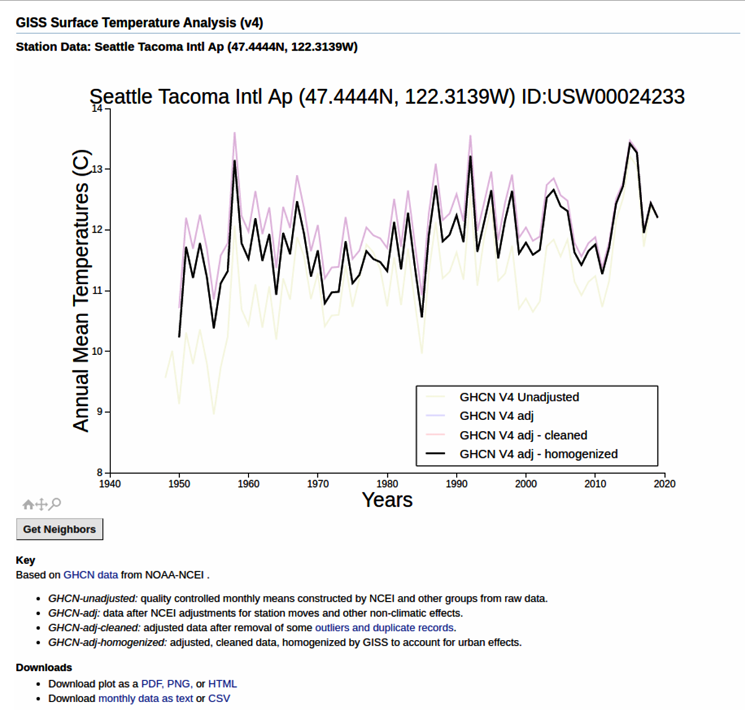
<caption>Surface temperature data from GISS</caption>

</center>

A link to download monthly data as CSV **at the bottom of this page** $\rightarrow$ select this $\rightarrow$ a file called **`station.csv`** will be downloaded. 

Open this

<center

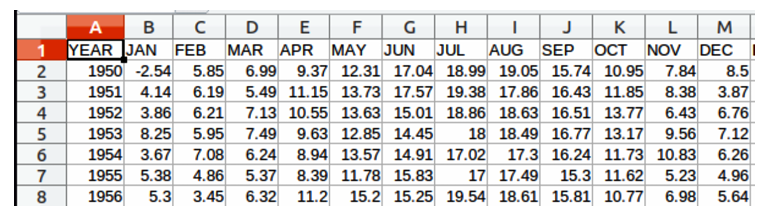

<caption>Exploring the data</caption>

</center>

Easy to process CSV data in Python, but as with any dataset, **do note the format**.

### **Reading GISS Data in Python**

In [146]:
def get_data():
    data_file = "./data/station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    
    lines = data.split('\n')
    header = lines[0].split(',')
    
    lines = lines[1:-2]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))
                    
    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    
    return time, series

Open the file at the indicated path $\rightarrow$ read in the entire file as a set of line (split **`\n`**) $\rightarrow$ loop through each line, ignoring the first line, and split them on **the comma character** into a new array called **`linedata`**. 

The items from **1** through **13** in this array indicate **the values** for the months **January** through **December** as strings $\rightarrow$ converted to floats $\rightarrow$ added to the array called **`temperatures`** $\rightarrow$ returned into **a Numpy array** called **`series`**, and **another Numpy array** called **`time`** - the same size as series. 

Using **`np.arange`**, the first element will be **1**, the second **2** $\rightarrow$ return **`time`** in steps from **1** to **the number of data points** and **`series`** as the data for that time.

In [147]:
time, series = get_data()

print('Time', time.shape, type(time))   
print('Series', time.shape, type(series))   

Time (900,) <class 'numpy.ndarray'>
Series (900,) <class 'numpy.ndarray'>


**Normalize a time series**

In [148]:
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

**Split into training and validation**


Choose the **`split time`** based on **the size of the data** — **900 data items** $\rightarrow$ split at **852** (reserving **four years** of data points for **validation**)

In [149]:
split_time = 852
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

In [156]:
print(series_train)

[-2.73623776e+00 -1.11487137e+00 -8.94566519e-01 -4.34631835e-01
  1.33522775e-01  1.04759465e+00  1.42443189e+00  1.43602688e+00
  7.96369820e-01 -1.29297045e-01 -7.30304132e-01 -6.10489214e-01
 -1.45305864e+00 -1.05689641e+00 -1.19217132e+00 -9.83770658e-02
  4.00207592e-01  1.14228708e+00  1.49206934e+00  1.19832954e+00
  9.21982234e-01  3.68978413e-02 -6.33679198e-01 -1.51103360e+00
 -1.51296610e+00 -1.05882891e+00 -8.81039029e-01 -2.20124482e-01
  3.75085109e-01  6.41769926e-01  1.38578192e+00  1.34133445e+00
  9.31644727e-01  4.02140091e-01 -1.01631394e+00 -9.62203973e-01
 -6.74261671e-01 -1.11873637e+00 -8.21131570e-01 -4.07576854e-01
  2.14687719e-01  5.23887507e-01  1.20992454e+00  1.30461697e+00
  9.72227199e-01  2.76527677e-01 -4.21104344e-01 -8.98431517e-01
 -1.56514356e+00 -9.06161511e-01 -1.06849140e+00 -6.10489214e-01
  2.84257672e-01  5.43212494e-01  9.50969714e-01  1.00507968e+00
  8.00234817e-01 -7.13220844e-02 -2.45246965e-01 -1.13612885e+00
 -1.30618874e+00 -1.40667

In [150]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48

dataset = windowed_dataset(series_train, window_size, 
                           batch_size, shuffle_buffer_size)

valid_dataset = windowed_dataset(series_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

Use the same **`windowed_dataset`** function as the convolutional network, **add a new dimension**. 

When using **RNNs**, **GRUs**, and **LSTMs** $\rightarrow$ **need the data in that shape**.

### **Using RNNs for Sequence Modeling**

Have the data from the **NASA CSV** in a windowed dataset $\rightarrow$ easy to create a model to train a predictor for it.  

**Naive model using RNNs**

In [151]:
model = tf.keras.models.Sequential([
            tf.keras.layers.SimpleRNN(100,                   return_sequences=True, 
            input_shape=[None, 1]),
            tf.keras.layers.SimpleRNN(100),
            tf.keras.layers.Dense(1)
])

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The Keras **`SimpleRNN`** layer is used. 

RNNs are **a class of neural networks** that are powerful for exploring sequence models. Notably, an RNN has **an internal loop** that **iterates over the time steps of a sequence** while **maintaining an internal state of the time steps it has seen so far**.

A **`SimpleRNN`** has **the output of each time step fed into the next time step**.

Compile and fit the model with the **same hyperparameters as before** or use **`Keras Tuner`** to find better ones.

In [152]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, metrics=["mae"])

history = model.fit(dataset, epochs=100,  verbose=1, validation_data=valid_dataset)

Epoch 1/100
     69/Unknown 2s 5ms/step - loss: 0.4886 - mae: 0.9018

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4883 - mae: 0.9014 - val_loss: 0.4604 - val_mae: 0.8630
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3728 - mae: 0.7640 - val_loss: 0.3534 - val_mae: 0.7335
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2750 - mae: 0.6398 - val_loss: 0.2688 - val_mae: 0.6259
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2036 - mae: 0.5423 - val_loss: 0.2066 - val_mae: 0.5439
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1519 - mae: 0.4627 - val_loss: 0.1629 - val_mae: 0.4821
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1185 - mae: 0.4029 - val_loss: 0.1321 - val_mae: 0.4323
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0965 - mae: 0.3624 - val_loss: 0.1113 - val_mae: 0.3927
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0839 - mae: 0.3352 - val_loss: 0.0963 - val_mae: 0.3601
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0728 - mae: 0.

In [153]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [154]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)

results = forecast[split_time - window_size:-1, -1]

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [155]:
# Create metric objects
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Update state with actual and predicted values
mae_metric.update_state(series_valid, results)

# Get the result
mae = mae_metric.result().numpy()

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.27734876


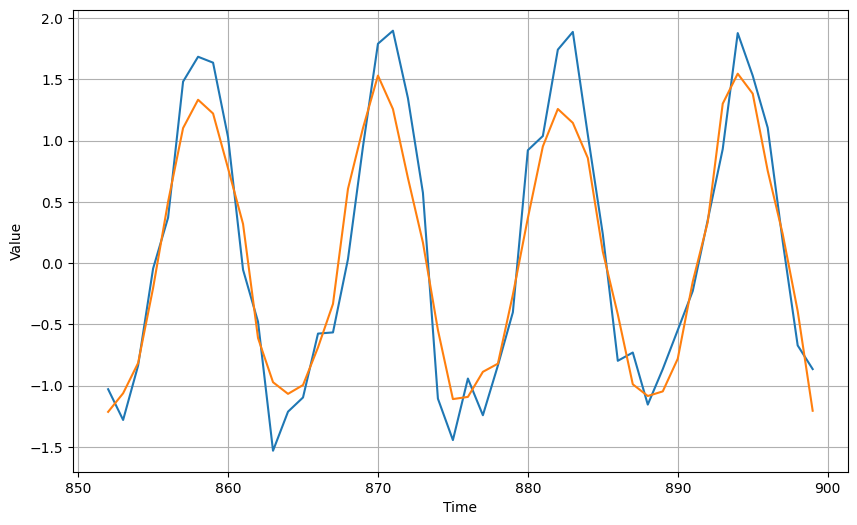

In [172]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    if label:
        plt.legend()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, results)

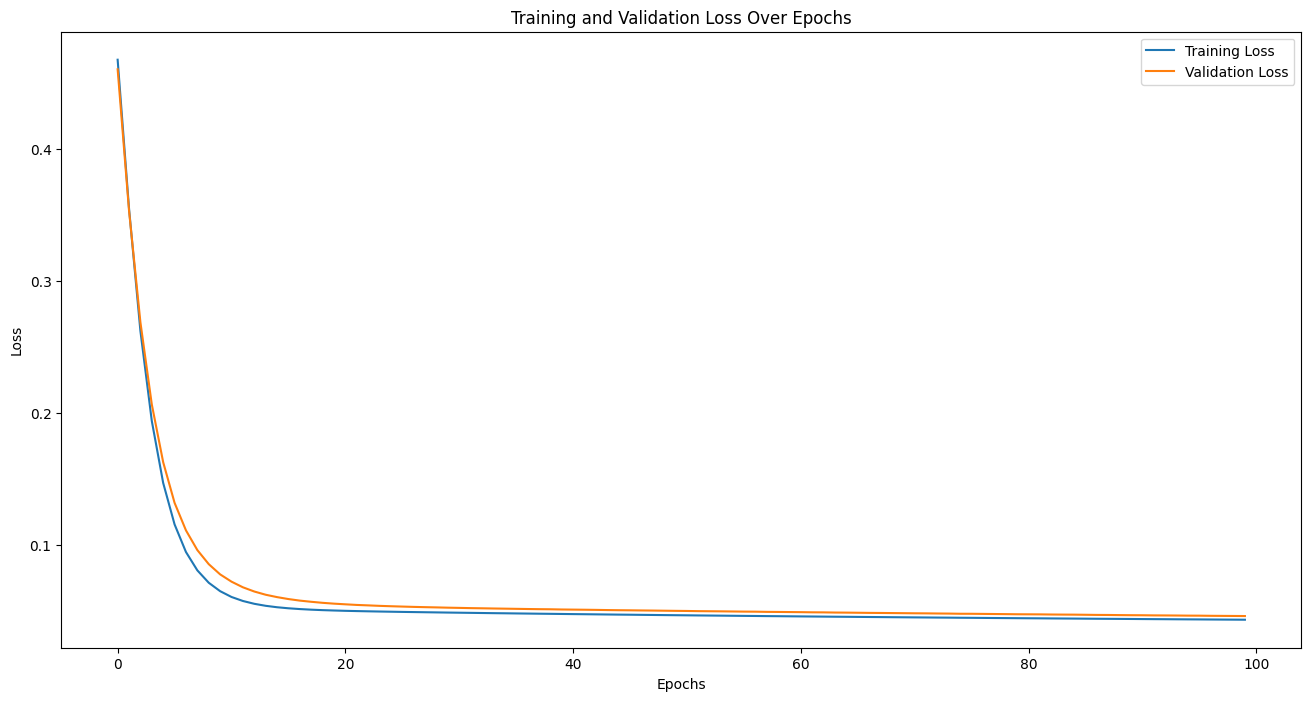

In [174]:
# Extract history
result = history.history

# Define epochs and loss data
epochs = [i for i in range(len(result['loss']))]  
lss = result['loss']
val_lss = result['val_loss']

# Plot loss and validation loss
plt.figure(figsize=(16, 8))
sns.lineplot(x=epochs, y=lss, label='Training Loss')  
sns.lineplot(x=epochs, y=val_lss, label='Validation Loss') 

# Add labels and legend
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Show plot
plt.show()

There’s **a healthy match** between **the training loss** and **the validation loss** but as **the epochs increase**, the model **begins to overfit on the training set**. 

Perhaps **a better number of epochs** would be around **40**. One reason could be the data being **monthly weather data is highly seasonal**. 

Another is that there is **a very large training set** and **a relatively small validation set**.

### **Using Other Recurrent Methods**

In addition to the **SimpleRNN**, TensorFlow has other recurrent layer types such as **gated recurrent units (GRUs)** and **long short-term memory layers (LSTMs)**.

Consider **the simple naive RNN**

In [ ]:
model = tf.keras.models.Sequential([
            tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], 
            return_sequences=True),
            tf.keras.layers.SimpleRNN(100),
            tf.keras.layers.Dense(1)
        ])

Replacing this with a **GRU**

In [ ]:
model = tf.keras.models.Sequential([
            tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True),
            tf.keras.layers.GRU(100),
            tf.keras.layers.Dense(1)
        ])

With an **LSTM**

In [ ]:
model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(100, input_shape=[None, 1], return_sequences=True),
            tf.keras.layers.LSTM(100),
            tf.keras.layers.Dense(1)
        ])

Experiment with **these layer types** as well as with different **hyperparameters**, **loss functions**, and **optimizers**. 

No one-size-fits-all solution $\rightarrow$ what works best in any given situation will depend on the data and the requirements for prediction with that data.

### **Using Dropout**

Encounter overfitting in the models where **the MAE** or **loss** for the **training data** is much **better than** with the **validation data** $\rightarrow$ use dropout. 


With dropout, neighboring neurons are **randomly dropped out** (ignored) **during training** to **avoid a familiarity bias**. When using **RNNs** $\rightarrow$ use **a `recurrent dropout` parameter**.
 
*What’s the difference?*

When using **RNNs** - have an input value and the neuron calculates an output value and a value that gets passed to the next time step. 

- **`Dropout`** will **randomly drop out the input values**. 
- **`Recurrent dropout`** will **randomly drop out the recurrent values that get passed to the next step**.

Consider the basic recurrent neural network architecture

<center>

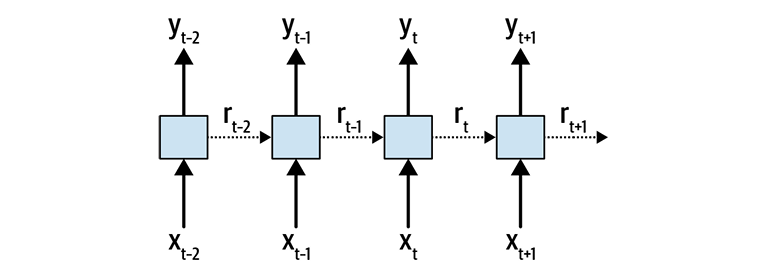

<caption>Recurrent neural network</caption>

</center>

The **inputs** to the layers at different time steps ($x$). 

The **current time** is $t$, and the steps shown are $t – 2$ through $t + 1$. 

The **relevant outputs** at the same time steps ($y$) are also shown. 

The **recurrent values** passed between time steps are indicated by the dotted lines and labeled as $r$.

$\Rightarrow$ Using **dropout** will **randomly drop out the $x$ inputs**.
$\Rightarrow$ Using **recurrent dropout** will **randomly drop out the $r$ recurrent values**.


Learn more about `How recurrent dropout works from a deeper mathematical perspective` in the paper **A Theoretically Grounded Application of Dropout in Recurrent Neural Networks** by Yarin Gal and Zoubin Ghahramani.

When using **recurrent dropout** is discussed by Gal in his research around **uncertainty in deep learning** where he demonstrates that ***the same pattern of dropout units*** should be ***applied at every time step*** and that a similar constant dropout mask should be applied at every time step. 

While dropout is typically random, Gal’s work was built into Keras so when using **tf.keras** the consistency recommended by his research is maintained.

To add **dropout** and **recurrent dropout** $\rightarrow$ use the relevant parameters on the layers. 

For example, adding them to the simple **`GRUs`**:

In [ ]:
model = tf.keras.models.Sequential([
            tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, 
        dropout=0.1, recurrent_dropout=0.1),
            tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
            tf.keras.layers.Dense(1),
        ])

Each parameter takes a value *between 0 and 1* indicating *the proportion of values to drop out*. A value of *0.1* will drop out *10%* of the requisite values.

**RNNs** using dropout will often **take longer to converge** $\rightarrow$ train them for **more epochs** to test for this. 
 
The results of training the preceding GRU with dropout and recurrent dropout on each layer set to 0.1 over 1,000 epochs.

<center>

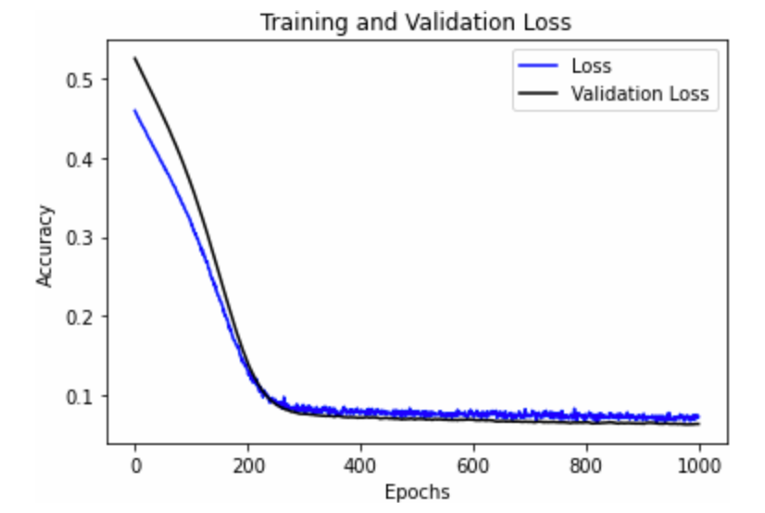

<caption>Training a GRU with dropout</caption>

</center>

The loss and MAE **decreased rapidly** until about **epoch 300** after which they *continued to decline but quite noisily*. 

**NOTE** - **Often see noise like this in the loss when using dropout** and it’s an indication that we may want to **tweak the amount of dropout** as well as the **parameters of the loss function**, such as **learning rate**. 
 
Predictions with this network were **shaped quite nicely** but there’s room for improvement in that **the peaks of the predictions are much lower than the real peaks**.

<center>

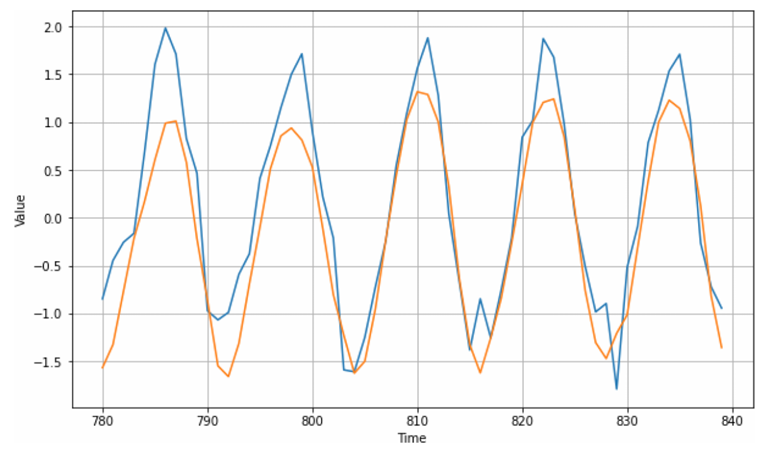

<caption>Predictions using a GRU with dropout</caption>

</center>

Predicting time sequence data using neural networks is **a difficult proposition** but **tweaking their hyperparameters** (particularly with tools such as **Keras Tuner**) can be a powerful way to **improve the model** and **its subsequent predictions**.

### **Using Bidirectional RNNs**

Another technique when classifying sequences is to use **bidirectional training**. 

$\rightarrow$ **Seem counterintuitive** by wonder *how future values could impact past ones*. But the time series values can contain **seasonality** where **values repeat over time** and when using a neural network to make predictions all we’re doing is sophisticated pattern matching. 

Given that data repeats, **a signal for how data can repeat might be found in future values** and when using **bidirectional training** $\rightarrow$ can train the network to try to **spot patterns** going from time $t$ to time $t + x$ as well as going from time $t + x$ to time $t$.


Consider the **GRU**. To make this **bidirectional** $\rightarrow$ wrap each GRU layer in a **`tf.keras.layers.Bidirectional`** call. 

This will effectively **train twice on each step** - once with the sequence data in **the original order**, and once with it **in reverse order**. The results are then merged before proceeding to the next step.

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
        dropout=0.1, recurrent_dropout=0.1)),
        tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
        tf.keras.layers.Dense(1),
 ])

<center>

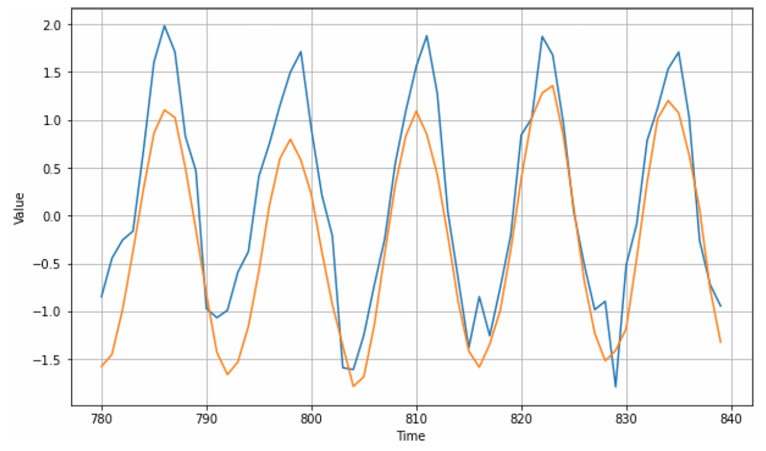

<caption>Training with a bidirectional GRU</caption>

</center>

A plot of the results of training with **a bidirectional GRU with dropout on the time series** $\rightarrow$ there’s **NO** major difference and the MAE ends up being **similar**. 

However, with **a larger data series** $\rightarrow$ a decent accuracy difference and additionally tweaking the training parameters such as **`window_size`** $\rightarrow$ **to get multiple seasons** — can have a pretty big impact.

This network has **an MAE (on the normalized data) of about .48** because it doesn’t seem to do too well on **the high peaks**. 
 
Retraining it with **a larger window** and **bidirectionality** produces **better results**: it has **a significantly lower MAE of about .28**.

<center>

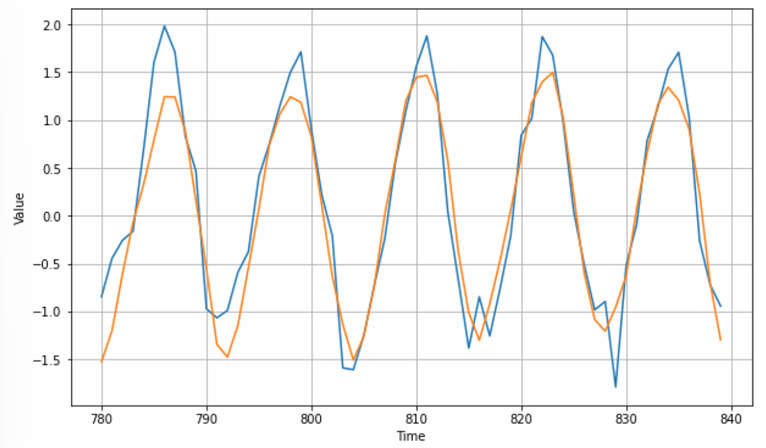

<caption>Larger window, bidirectional GRU results</caption>

</center>

Experiment with **different network architectures** and **different hyperparameters** to improve the overall predictions. 

$\Rightarrow$ The **ideal** choices are very much **dependent** on the **data**